In [1]:
# готовый код
import numpy as np
import matplotlib.pyplot as plt 
import time

def W(n,k,N):#поворотный коэффициент
    return np.around(np.exp(-2j*np.pi*n*k/N),9)
    
def X_k(x,k):#X[k]
    N = len(x)
    return sum(x[n]*W(n,k,N) for n in range(N))

def DFT(x):#преобразование Фурье
    N = len(x)
    X = np.array([])
    for k in range(N): 
        X = np.append(X,X_k(x,k))
    return X

def dividers(N):#находим наименьший делитель 
    for i in range(2,int(N**0.5)+1):
        if N%i ==0:
            return i
    return False
    
def div_index(a,b):#разделить индексы
    m_s = range(a)
    p_s = range(b)
    return [[p*a + m for p in p_s] for m in m_s]

def FFT(x):#быстрое преобразование Фурье
    N = len(x)
    M = dividers(N)
    if not M:
        return DFT(x)
        
    L = N//M
    n_lists = div_index(M,L)#делим индексы
    y_s_div = [FFT(x[n_list]) for n_list in n_lists]#разделяем иксы по индексам и тут же их преобразовываем по Фурье
    z_s_div = [np.array([W(m,q,N)*y_s_div[m][q] for m in range(M)]) for q in range(L)]#составляем L сигналов zq[m]
    v_s_div = np.array([FFT(z) for z in z_s_div])#преобразовываем по Фурье L сигналов zq[m]
    X = np.around(v_s_div.T.flatten(),6)#пишем в нужном виде
    return X

def FFTF(N,sample_spacing):#функция для нахождения частот
    f = np.arange(0,N,1/(N*sample_spacing))
    return np.hstack([f[:int(np.ceil(N/2))],f[:int(np.ceil(N/2+10e-9))][1:][::-1]*(-1)])
    

In [2]:
data = np.genfromtxt('1.csv', delimiter=';', dtype=None).T

In [3]:
x_1,x_2 = data[0],data[1]

In [4]:
t = np.arange(x_1.size)

In [5]:
N = 2**14*3**3 #близкое значение к общему размеру, но легко раскладываемое

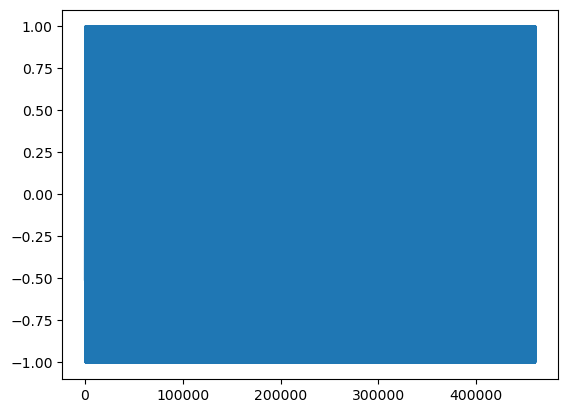

In [6]:
plt.plot(t,x_2)#для x_2 такое же
plt.show()

In [10]:
t1 = time.perf_counter()
X = FFT(x_2[:N])
t2 = time.perf_counter()
print('Прошло времени:',round(t2-t1,5),'c')
X_abs = np.abs(X)/N

Прошло времени: 985.39844 c


In [11]:
fx = FFTF(N, 1/N)

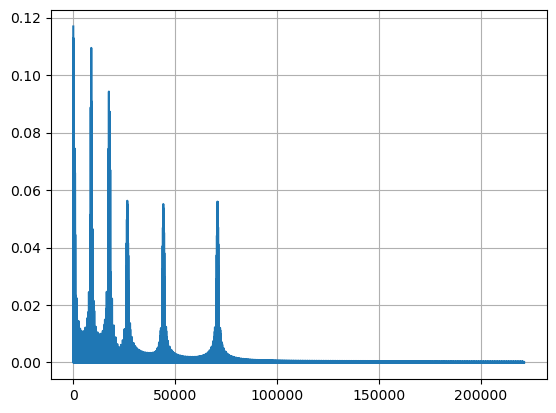

In [12]:
#plt.figure(figsize=(6.4,4.8*2))
plt.plot(fx[:N//2],X_abs[:N//2])
#plt.yticks(np.arange(min(X_abs[:400]),max(X_abs[:400])+1,5))
plt.grid()
plt.show()

In [13]:
def notch_filter(fs, f, BW, X):#Режекторный фильтр fs-частота дискретизации, f-резонансная, BW - ширина пропускания
    f = f/fs
    BW = BW/fs
    R = 1-3*BW
    K = (1-2*R*np.cos(2*np.pi*f)+R**2)/(2-2*np.cos(2*np.pi*f))
    a_0,a_1,a_2 = K,-2*K*np.cos(2*np.pi*f),K
    b_1,b_2 = 2*R*np.cos(2*np.pi*f),-(R**2)
    Y=np.copy(X)
    for i in range(2,X.size):
        Y[i] = a_0*X[i] + a_1*X[i-1] + a_2*X[i-2] + b_1*Y[i-1] + b_2*Y[i-2]
    return Y

In [14]:
#y = notch_filter(N,0,0,x_1[:N])
y=np.copy(x_2[:N])
for i in range(1000,100000):#тут я ищу пики, от 1000 чтобы синусоиду оставить, до 10*5 чтобы меньше операций было
    if X_abs[i]>0.3*X_abs[0] and (X_abs[i]==max(X_abs[i-500:i+500])):
        y = notch_filter(N,i,i//1.6,y)# ширину в i//1.6 выбрал подбором

In [16]:
Y = FFT(y[:N])

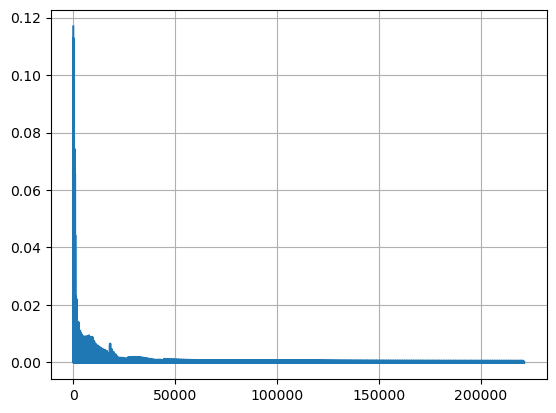

In [17]:
Y_abs = np.abs(Y)/N
plt.plot(fx[:N//2],Y_abs[:N//2])
plt.grid()
plt.show()

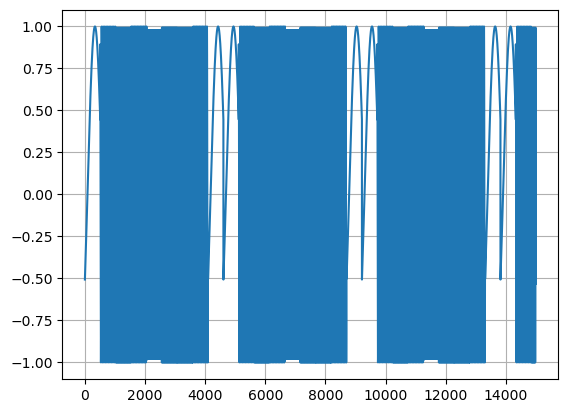

In [9]:
plt.plot(t[:15000],x_2[:15000])
plt.grid()
plt.show()

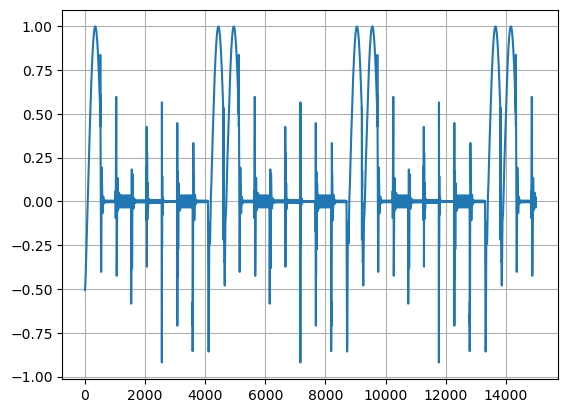

In [15]:
plt.plot(t[:15000],y[:15000])
plt.grid()
plt.show()